# Data Generation Tutorial: Data-Free Quantization with the Model Compression Toolkit

[Run this tutorial in Google Colab](https://colab.research.google.com/github/sony/model_optimization/blob/main/tutorials/notebooks/example_pytorch_data_generation.ipynb)

In this tutorial, we will explore how to generate synthetic images using the Model Compression Toolkit (MCT) and the Data Generation Library. These generated images are based on the statistics stored in the model's batch normalization layers and can be usefull for various compression tasks, such as quantization and pruning. We will use the generated images as a representative dataset to quantize our model to 8-bit using MCT's Post Training Quantization (PTQ).

We will cover the following steps:
1. **Setup** Install and import necessary libraries and load a pre-trained model.
2. **Configuration**: Define the data generation configuration.
3. **Data Generation**: Generate synthetic images.
4. **Visualization**: Visualize the generated images.
5. **Quantization**: Quantize our model to 8-bit using PTQ with the generated images as a representative dataset. This is called **"Data-Free Quantization"** since no real data is used in the quantization process.

## Step 1: Setup
Install the necessary packages:

In [ ]:
!pip install -q torch torchvision
!pip install -q model-compression-toolkit

Imports:

In [1]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import model_compression_toolkit as mct
import matplotlib.pyplot as plt
import numpy as np

Load the model from the torchvision library:

In [17]:
# Load a pre-trained model (e.g., ResNet18)
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

## Step 2: Define a Data Generation Configuration
Next, we need to specify the configuration for data generation using 'get_pytorch_data_generation_config'. This configuration includes parameters such as the number of iterations, optimizer, batch size, and more. Customize these parameters according to your needs.

In [18]:
data_gen_config = mct.data_generation.get_pytorch_data_generation_config(
    n_iter=500,                      # Number of iterations
    optimizer=torch.optim.RAdam,     # Optimizer
    data_gen_batch_size=32,          # Batch size for data generation
    initial_lr=16,                   # Initial learning rate
    output_loss_multiplier=5e-7,     # Multiplier for output loss
    extra_pixels=32, 
    # ... (customize other parameters)
)

## Step 3: Generate Synthetic Images

Now, let's generate synthetic images using the 'pytorch_data_generation_experimental' function. Specify the number of images you want to generate and the output image size.

In [19]:
n_images = 256              # Number of images to generate
output_image_size = 224     # Size of output images

generated_images = mct.data_generation.pytorch_data_generation_experimental(
    model=model,
    n_images=n_images,
    output_image_size=output_image_size,
    data_generation_config=data_gen_config
)

Number of layers = 20


Total Loss: 0.00150, BN Loss: 0.00149, Output Loss: 0.00001: 100%|██████████| 500/500 [08:49<00:00,  1.06s/it]

Total time to generate 256 images (seconds): 529


## Step 4: Visualization
Lets begin by defining some functions to display the generated images in a grid:

In [9]:
def plot_image_grid(images, reverse_preprocess=False, titles=[], ncols=None, cmap='gray', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    images = [plot_image(img, reverse_preprocess, mean, std, plot_img=False) for img in images]
    if len(titles) < len(images):
        titles += ['_' for _ in range(len(images) - len(titles))]
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax, t in zip(imgs, axes.flatten(), titles):
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)
            ax.title.set_text(t)
    plt.show()


def plot_image(image, reverse_preprocess=False, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], plot_img=True):
    image = image.detach().cpu().numpy()
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    if reverse_preprocess:
        new_image = np.round(((image.astype(np.float32) * std) + mean) * 255).astype(np.uint8)
    else:
        new_image = image
    if plot_img:
        plt.imshow(new_image)
        plt.show()
    return new_image

Now, lets visualize our generated images:

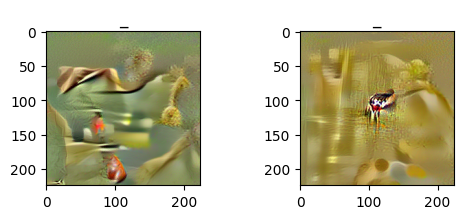

In [22]:
plot_image_grid(generated_images[69:71], True)

## Step 5: Post Training Quantization
In order to evaulate our generated images, we will use them to quantize the model using MCT's PTQ.This is called **"Data-Free Quantization"** because no real data is used in the quantization process. 

### Setup for evaluation on the ImageNet dataset
Here we define functions for evaluation on ImageNet:


In [11]:
from torchvision import datasets, transforms
from tqdm import tqdm

# If GPU available, move the model to GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load a pre-trained model (e.g., ResNet18)
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

def get_validation_loader(imagenet_validation_folder, batch_size=50):
    preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    data_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(imagenet_validation_folder, preprocess),
        batch_size=batch_size, shuffle=False,
        num_workers=8, pin_memory=True)
    return data_loader

def eval(outputs, labels, topk=(1,)):
    maxk = max(topk)

    _, pred = outputs.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(labels.view(1, -1).expand_as(pred))
    return correct


def accuracy(outputs, labels, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""

    correct = eval(outputs, labels)

    batch_size = labels.size(0)

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res, correct


def pytorch_model_accuracy_evaluation(model, val_data_loader) -> float:
    model = model.to(DEVICE)
    model.eval()
    acc_top1 = 0

    batch_cntr = 1
    iterations = len(val_data_loader)
    with torch.no_grad():
        for input_data, target_data in tqdm(val_data_loader):
            inputs_batch = input_data.to(DEVICE)
            target_batch = target_data.to(DEVICE)


            predicted_batch = model(inputs_batch)

            batch_avg_top_1, correct_inds = accuracy(outputs=predicted_batch, labels=target_batch)
            acc_top1 += batch_avg_top_1[0].item()
    
    
            batch_cntr += 1
            if batch_cntr > iterations:
                break
    acc_top1 /= iterations
    return acc_top1    

Here we define configurations for MCT's PTQ:

In [12]:
num_calibration_iter = 10
batch_size=50
target_platform_cap = mct.get_target_platform_capabilities("pytorch", "default")
core_config = mct.core.CoreConfig(quantization_config=mct.core.QuantizationConfig())

Specify the path to the imagenet validation folder:

In [13]:
imagenet_validation_folder = '/path/to/imagenet/validation/folder'
val_loader = get_validation_loader(imagenet_validation_folder)

### Quantization with our generated images
In this section we use our generated images as a representative dataset for PTQ:

In [14]:
batches_inds = np.random.choice(len(generated_images),
                                size=(int(len(generated_images) / batch_size),batch_size),
                                replace=False)
def representative_data_gen():
    for nn in range(num_calibration_iter):
        nn_mod = nn % len(batches_inds)
        yield [np.concatenate([generated_images[b].detach().cpu().numpy() for b in batches_inds[nn_mod]], axis=0)]
        
# run post training quantization on the model to get the quantized model output
quantized_model_generated_data, quantization_info = mct.ptq.pytorch_post_training_quantization_experimental(
    in_module=model,
    representative_data_gen=representative_data_gen,
    core_config=core_config,
    target_platform_capabilities=target_platform_cap
)

10it [00:28,  2.88s/it]


Using new experimental wrapped and ready for export models. To disable it, please set new_experimental_exporter to False when calling pytorch_post_training_quantization_experimental. If you encounter an issue please file a bug.


### Evaluation of the quantized model's performance
Here we evaluate our model's top 1 classification performance after PTQ on the ImageNet validation dataset.

In [16]:
accuracy_values = pytorch_model_accuracy_evaluation(quantized_model_generated_data, val_loader)
print('Float model\'s reported top 1 performance on ImageNet: 69.86')
print(f'Data-Free quantized model\'s top 1 performance on ImageNet: {accuracy_values}')

100%|█████████▉| 999/1000 [01:06<00:00, 14.95it/s]

Float model's reported top 1 performance: 69.86
Compressed model using generated images top 1 performance on ImageNet: 69.578


## Conclusion:
In this tutorial we demonstrated how to generate synthetic images from a trained model and how to use those images for quantizing the model. The quantized model's size is x4 compressed compared to the original float model, however, its performance is similar to the repored float result. No real data was needed in this process. 

## Copyrights:
Copyright 2023 Sony Semiconductor Israel, Inc. All rights reserved.
Licensed under the Apache License, Version 2.0 (the “License”); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an “AS IS” BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.